# Speech Emotion Recognition

## Data Preprocessing

---

### Imports

In [1]:
import os
from itertools import combinations

import librosa, librosa.display
import IPython.display as ipd
from random import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tqdm import tqdm

# my helpers
from ser_helpers import augmentation, data_manager

### Define Constants

In [2]:
# audio constants
SIGNAL_DURATION = 3
TARGET_MFCC_COUNT = 130
SAMPLE_RATE = 22050
HOP_LENGTH = 512

if SIGNAL_DURATION * SAMPLE_RATE > TARGET_MFCC_COUNT * HOP_LENGTH:
    raise Exception('Signal duration is too short for the target mfcc count')

### Create a dataframe

#### Load data

In [3]:
dir_path = data_manager.RAW_DATA_PATH
dir_list = os.listdir(dir_path)
dir_list.sort()
print(dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


#### Declaring the labels

In [4]:
emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
intensity_list = ['normal', 'strong']
statement_list = ['kids', 'dogs']
gender_list = ['female', 'male']

#### Create the actual dataframe

In [5]:
columns = ['path', 'source', 'actor', 'gender', 'gender_label', 'statement', 'repetition', 'intensity', 'emotion', 'emotion_label', 'augmentation', 'mfcc']
data_df = pd.DataFrame(columns=columns)

count = 0
for dir in dir_list:
  file_list = os.listdir(dir_path + dir)
  for file in file_list:
    nm = file.split('.')[0].split('-')

    file_path = dir_path + dir + '/' + file
    source = int(nm[1])
    emotion = int(nm[2]) - 1
    emotion_label = emotion_list[emotion]
    intensity = int(nm[3]) - 1
    statement = int(nm[4]) - 1
    repetition = int(nm[5])
    actor = int(nm[6])
    gender = actor%2
    gender_label = gender_list[gender]

    data_df.loc[count] = [file_path, source, actor, gender, gender_label, statement, repetition, intensity, emotion, emotion_label, 'none', '']
    count += 1

print(len(data_df))
data_df.head(3)

1440


,path,source,actor,gender,gender_label,statement,repetition,intensity,emotion,emotion_label,augmentation,mfcc
0,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,0,1,0,0,neutral,none,
1,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,0,2,0,0,neutral,none,
2,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,1,1,0,0,neutral,none,


### Data Exploration

In [6]:
# set plotting style for dark-themed notebook
plt.style.use('ggplot')

#### Plotting our data distribution

Text(0.5, 0, 'Emotion')

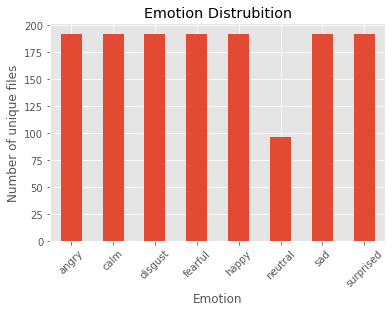

In [7]:
ax = data_df.groupby('emotion_label')['path'].nunique().plot(
    kind='bar',
    title='Emotion Distrubition',
    rot=45
)
ax.set_ylabel('Number of unique files')
ax.set_xlabel('Emotion')

#### Plotting a randomly selected file

In [8]:
# select an example
filename = data_df.path[30]
print(filename)

signal, sr = librosa.load(filename, sr=SAMPLE_RATE, duration=3)

ipd.Audio(signal, rate=sr)

../data/Audio_Speech_Actors_01-24/Actor_01/03-01-05-01-02-01-01.wav


In [49]:
def plot_signal(signal, title, save=False, save_title='some_plot'):
    plt.figure(figsize=(12, 3))
    plt.title(title, pad=10)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    librosa.display.waveplot(signal, sr=sr)
    plt.tight_layout()
    if save:
        plt.savefig('../plots/{}.png'.format(save_title))
    else:
        plt.show()

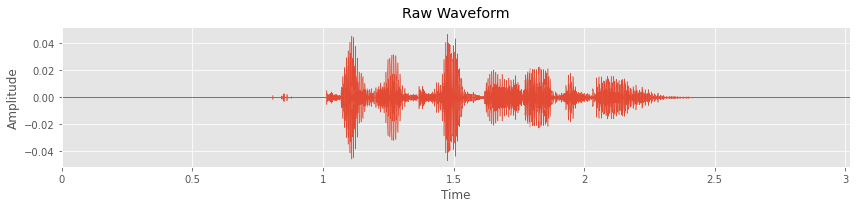

In [50]:
plot_signal(signal, 'Raw Waveform')

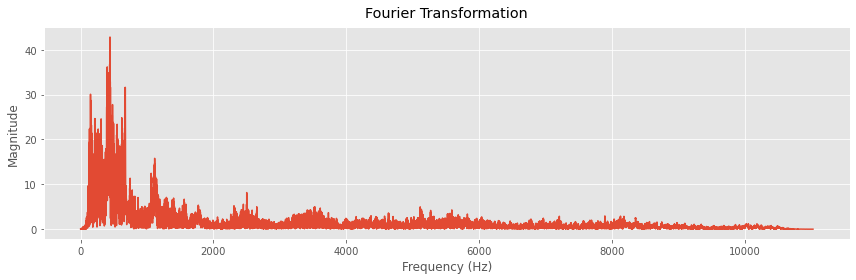

In [11]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency) / 2)]
left_magnitude = magnitude[:int(len(frequency) / 2)]

plt.figure(figsize=(12, 4))
plt.title("Fourier Transformation", pad=10)
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.savefig('../plots/fft.png')

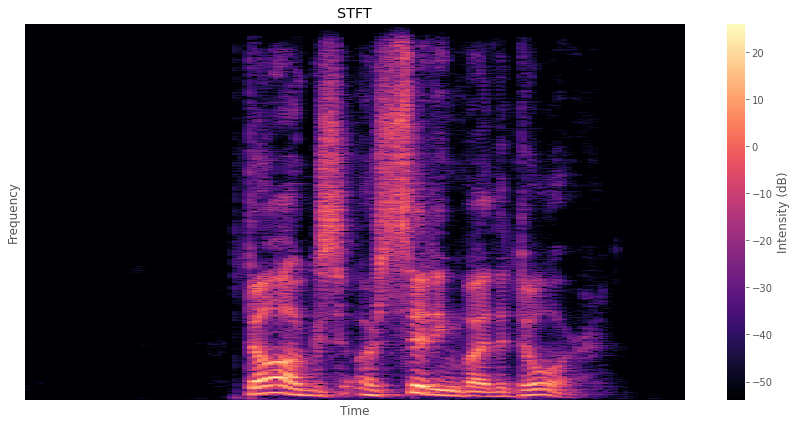

In [12]:
n_fft = 2048  # number of samples per fft
hop_length = 512  # number of samples we shift after each fft

stft = librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(12, 6))
plt.title('STFT')
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
cbar = plt.colorbar(label='Intensity (dB)')
plt.tight_layout()
plt.savefig('../plots/spectrogram.png')

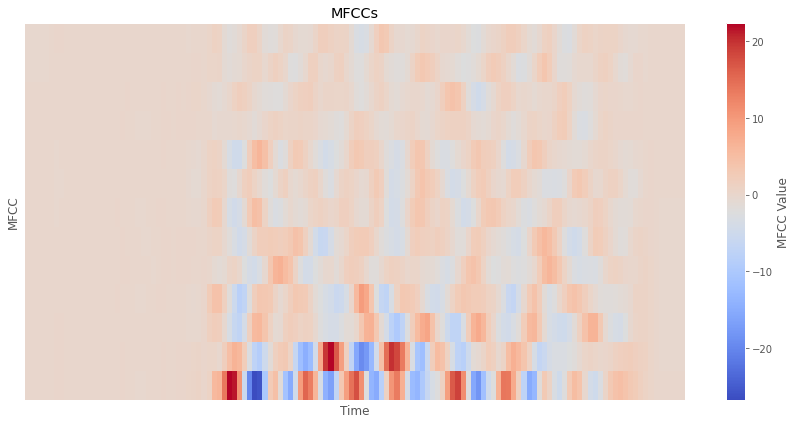

In [13]:
mfccs = librosa.feature.mfcc(signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfccs, order=2)

plt.figure(figsize=(12, 6))
plt.title('MFCCs')
librosa.display.specshow(delta2_mfcc, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar(label='MFCC Value')
plt.tight_layout()
plt.savefig('../plots/mfcc.png')

### Various plots of a random trimmed file

In [14]:
trimmed_signal, bb = librosa.effects.trim(signal, top_db=30)
print(len(signal)/SAMPLE_RATE)
print(len(trimmed_signal)/SAMPLE_RATE)
ipd.Audio(trimmed_signal, rate=sr)

3.0
1.5325170068027212


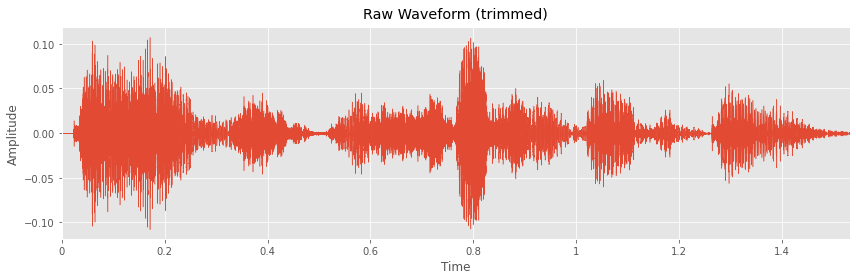

In [15]:
plot_signal(trimmed_signal, "Raw Waveform (trimmed)")

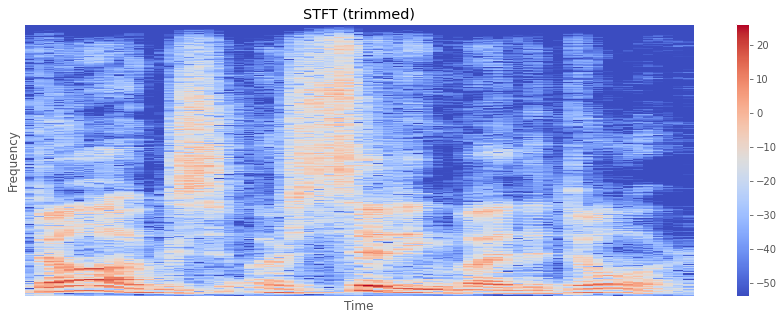

In [16]:
n_fft = 2048  # number of samples per fft
hop_length = 512  # number of samples we shift after each fft

stft = librosa.core.stft(trimmed_signal, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(15, 5))
plt.title('STFT (trimmed)')
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

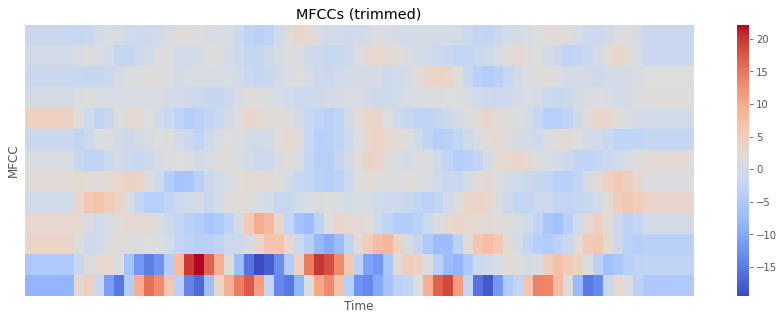

In [17]:
mfccs = librosa.feature.mfcc(trimmed_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc_trim = librosa.feature.delta(mfccs, order=2)

plt.figure(figsize=(15, 5))
plt.title('MFCCs (trimmed)')
librosa.display.specshow(delta2_mfcc_trim, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

### Data Augmentation

In [18]:
def get_mfccs(signal, samplerate, use_delta2=False):
    mfcc = librosa.feature.mfcc(signal, sr=samplerate, n_mfcc=13, n_fft=2048, hop_length=HOP_LENGTH)

    if use_delta2:
        mfcc = librosa.feature.delta(mfcc, order=2) # not working as intended yet

    return mfcc.T.tolist()

# def extract_features(df):
#
#     mfcc_list = []
#
#     for i in tqdm(range(len(df))):
#         signal, sr = librosa.load(df.path[i], sr=SAMPLE_RATE, duration=SIGNAL_DURATION)
#         mfcc_list.append(get_mfccs(signal, sr))
#
#     df['mfcc'] = mfcc_list
#
#     return df

def get_signal(path):
    signal, sr = librosa.load(path, sr=SAMPLE_RATE, duration=SIGNAL_DURATION)

    # zero-pad signal
    dest_length = TARGET_MFCC_COUNT * HOP_LENGTH
    padded_signal = np.pad(signal, (0, dest_length - len(signal)), 'constant')

    return padded_signal, sr

def get_feature_df(df, aug_style=''):
    """
    Get the dataframe with MFCC features with or without augmentation
    :param df:
    :param aug_style:
    :return:
    """
    feature_df = df.copy()

    for i in tqdm(range(len(feature_df))):
        signal, sr = get_signal(df.path[i])

        if aug_style in augmentation.augmentation_styles:
            signal = get_augmented_signal(signal, sr, aug_style)
            feature_df.iloc[i]['augmentation'] = aug_style

        feature_df.iloc[i]['mfcc'] = get_mfccs(signal, sr)

    return feature_df

# not working as intended yet
# def get_aug_combinations():
#     combinations = []
#     for i in range(1, len(augmentation.augmentation_styles)):
#         combinations.append(
#             list(combinations(augmentation.augmentation_styles, i))
#         )
#     return combinations

def get_augmented_signal(signal, sr, augmentation_style):
    """
    Augment a passed signal with the provided augmentation style
    :param signal:
    :param sr:
    :param augmentation_style:
    :return:
    """
    if augmentation_style == augmentation.AUG_NOISE:
        return augmentation.add_noise(signal)

    if augmentation_style == augmentation.AUG_SHIFT:
        return augmentation.add_shift(signal)

    if augmentation_style == augmentation.AUG_NOISE:
        return augmentation.add_pitch(signal, sr)

    if augmentation_style == augmentation.AUG_NOISE:
        return augmentation.add_noise(signal)

    return signal

In [19]:
# pd.options.mode.chained_assignment = None
# df_train, df_test = train_test_split(data_df, test_size=0.2)
# df_train["usage"] = "train"
# df_test["usage"] = "test"
# df_train = df_train.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

In [20]:
# df_train = extract_features(df_train)
# df_test = extract_features(df_test)
# df_train_noise = get_augmented_df(df_train, 'noise')
# df_train_shift = get_augmented_df(df_train, 'shift')
# df_train_pitch = get_augmented_df(df_train, 'pitch')
#
# df_all_nsp = pd.concat([
#     df_train,
#     df_train_noise,
#     df_train_shift,
#     df_train_pitch,
#     df_test
# ], ignore_index=True).reset_index(drop=True)
#
# df_all_n = pd.concat([
#     df_train,
#     df_train_noise,
#     df_test
# ], ignore_index=True).reset_index(drop=True)
#
# print('\nSaving df_all_augmented file...')
# df_all_nsp.to_pickle(DF_ALL_AUG_PATH)
# print("File size: {} MB".format(os.path.getsize(DF_ALL_AUG_PATH) / (1024 * 1024)))

#### Selecting a random file to augment

In [ ]:
def plot_dual_signal(signal, signal2, title, save=False, save_title='../plots/some_plot.png'):
    plt.figure(figsize=(12, 4))
    plt.title(title, pad=10)
    plt.xlabel("Time in Seconds")
    plt.ylabel("Amplitude")
    librosa.display.waveplot(signal, sr=sr)
    plt.tight_layout()
    if save:
        plt.savefig('../plots/raw_waveform.png')
    else:
        plt.show()

[-1.0549581e-04 -1.7324212e-04 -1.4215290e-04 ...  1.1017560e-04
  9.7027485e-05  1.0333952e-04]
[ 9.70274850e-05  1.03339516e-04 -1.05495812e-04 ...  9.66920124e-05
  1.17839896e-04  1.10175599e-04]


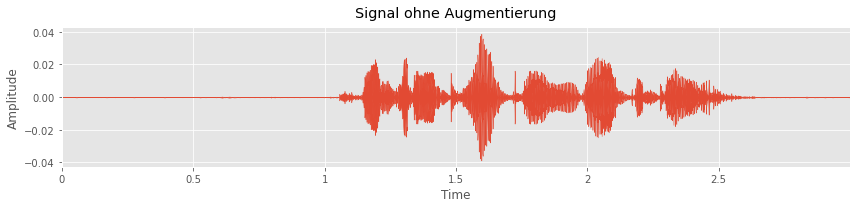

In [63]:
signal, sr = librosa.load(data_df.path[420], sr=SAMPLE_RATE, duration=SIGNAL_DURATION)
plot_signal(signal, "Signal ohne Augmentierung", True, 'raw_waveform')
ipd.Audio(signal, rate=sr)

#### Add Noise

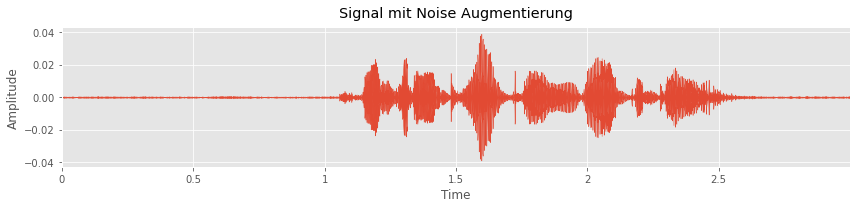

In [55]:
signal_noise = augmentation.add_noise(signal)
plot_signal(signal_noise, "Signal mit Noise Augmentierung", True, 'noise_aug')
ipd.Audio(signal_noise, rate=sr)

#### Apply Time Shift

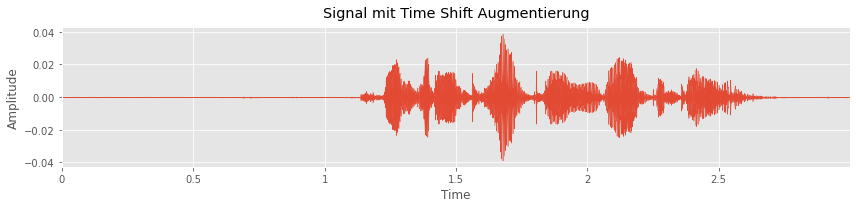

In [60]:
signal_shift = augmentation.add_shift(signal)
plot_signal(signal_shift, "Signal mit Time Shift Augmentierung", True, 'shift_aug')
ipd.Audio(signal_shift, rate=sr)

#### Apply Pitch Shift

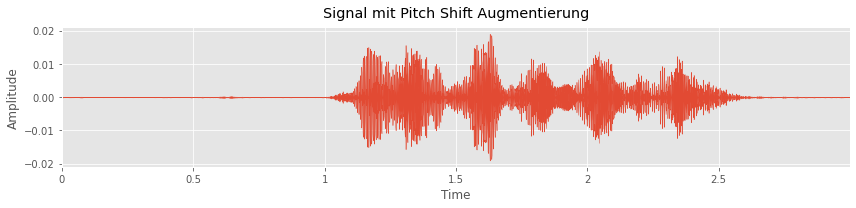

In [61]:
signal_pitch = augmentation.add_pitch(signal, sample_rate=sr)
plot_signal(signal_pitch, "Signal mit Pitch Shift Augmentierung", True, 'pitch_aug')
ipd.Audio(signal_pitch, rate=sr)

#### Apply Stretch

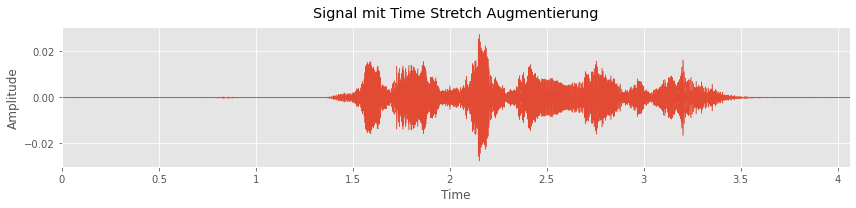

In [68]:
signal_pitch = augmentation.add_stretch(signal)
plot_signal(signal_pitch, "Signal mit Time Stretch Augmentierung", True, 'strech_aug')
ipd.Audio(signal_pitch, rate=sr)

In [67]:
# df_all_file_available = os.path.isfile(DF_ALL_PATH)
# df_male_file_available = os.path.isfile(DF_MALE_PATH)
# df_female_file_available = os.path.isfile(DF_FEMALE_PATH)
#
#
# if not df_all_file_available:
#     print("\nExtracting all features...")
#     data_df = get_feature_df(df=data_df)
#
# if not df_male_file_available:
#     print("\nExtracting male features...")
#     df_male = data_df[data_df['gender'] == 1]
#     df_male.reset_index(inplace=True, drop=True)
#     df_male = get_feature_df(df=df_male)
#
# if not df_female_file_available:
#     print("\nExtracting female features...")
#     df_female = data_df[data_df['gender'] == 0]
#     df_female.reset_index(inplace=True, drop=True)
#     df_female = get_feature_df(df=df_female)
#
# if not df_all_file_available:
#     save_df(DF_ALL_PATH)
#     print('\nSaving df_all file...')
#     data_df.to_pickle(DF_ALL_PATH)
#     print("File size: {} MB".format(os.path.getsize(DF_ALL_PATH) / (1024 * 1024)))
#
# if not df_male_file_available:
#     print('\nSaving df_male file...')
#     data_df.to_pickle(DF_MALE_PATH)
#     print("File size: {} MB".format(os.path.getsize(DF_MALE_PATH) / (1024 * 1024)))
#
# if not df_female_file_available:
#     print('\nSaving df_female file...')
#     data_df.to_pickle(DF_FEMALE_PATH)
#     print("File size: {} MB".format(os.path.getsize(DF_FEMALE_PATH) / (1024 * 1024)))

In [26]:
signal, sr = get_signal(data_df.path[1])
data_df.iloc[1]['mfcc'] = get_mfccs(signal, sr)

data_df.head()
# feature_df = get_feature_df(data_df)
# feature_df_noise = get_feature_df(data_df, augmentation.AUG_NOISE)
# feature_df_pitch = get_feature_df(data_df, augmentation.AUG_PITCH)
# feature_df_shift = get_feature_df(data_df, augmentation.AUG_SHIFT)
# feature_df_stretch = get_feature_df(data_df, augmentation.AUG_STRETCH)

,path,source,actor,gender,gender_label,statement,repetition,intensity,emotion,emotion_label,augmentation,mfcc
0,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,0,1,0,0,neutral,none,
1,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,0,2,0,0,neutral,none,"[[-864.8902862773604, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,1,1,0,0,neutral,none,
3,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,1,2,0,0,neutral,none,
4,../data/Audio_Speech_Actors_01-24/Actor_01/03-...,1,1,1,male,0,1,0,1,calm,none,


In [27]:
# feature_df.to_pickle(DATA_PATH + 'df_normal.pkl')
# feature_df_noise.to_pickle(DATA_PATH + 'df_noise.pkl')
# feature_df_pitch.to_pickle(DATA_PATH + 'df_pitch.pkl')
# feature_df_shift.to_pickle(DATA_PATH + 'df_shift.pkl')
# feature_df_stretch.to_pickle(DATA_PATH + 'df_stretch.pkl')

### Save Feature Data Files

In [28]:
# save dataframes as pickle if not saved yet or override is active

override_saved_data = False

if not os.path.isfile(data_manager.PATH_DF_NORMAL) or override_saved_data:
    feature_df = get_feature_df(data_df)
    feature_df.to_pickle(data_manager.PATH_DF_NORMAL)

if not os.path.isfile(data_manager.PATH_DF_NOISE) or override_saved_data:
    feature_df_noise = get_feature_df(data_df, augmentation.AUG_NOISE)
    feature_df_noise.to_pickle(data_manager.PATH_DF_NOISE)

if not os.path.isfile(data_manager.PATH_DF_PITCH) or override_saved_data:
    feature_df_pitch = get_feature_df(data_df, augmentation.AUG_PITCH)
    feature_df_pitch.to_pickle(data_manager.PATH_DF_PITCH)

if not os.path.isfile(data_manager.PATH_DF_SHIFT) or override_saved_data:
    feature_df_shift = get_feature_df(data_df, augmentation.AUG_SHIFT)
    feature_df_shift.to_pickle(data_manager.PATH_DF_SHIFT)

if not os.path.isfile(data_manager.PATH_DF_STRETCH) or override_saved_data:
    feature_df_stretch = get_feature_df(data_df, augmentation.AUG_STRETCH)
    feature_df_stretch.to_pickle(data_manager.PATH_DF_STRETCH)

In [29]:
# data exploration
# time_list = []
# time_list2 = []
#
# for i in tqdm(range(len(data_df))):
#     signal, sr = librosa.load(data_df.path[i], sr=SAMPLE_RATE)
#     signalt, index = librosa.effects.trim(signal, top_db=30)
#     x = librosa.get_duration(signal)
#     y = librosa.get_duration(signalt)
#     time_list.append(x)
#     time_list2.append(y)

In [30]:
# feature_df2 = pd.read_pickle(data_manager.PATH_DF_NORMAL)
# feature_df2.head()

In [31]:
# data exploration
time_list = []

for i in tqdm(range(len(data_df))):
    time_list.append(librosa.get_duration(filename=data_df.path[i]))

100%|██████████| 1440/1440 [00:16<00:00, 88.47it/s]


In [32]:
# plt.plot(time_list)
# plt.show()

In [33]:
# print('normal')
print('mean', np.mean(time_list))
print('median', np.median(time_list))
print('max', np.max(time_list))
print('min', np.min(time_list))

# print('\ntrimmed')
# print('mean', np.mean(time_list2))
# print('median', np.median(time_list2))
# print('max', np.max(time_list2))
# print('min', np.min(time_list2))


mean 3.7006648148148145
median 3.6703333333333332
max 5.2719375
min 2.9362708333333334


In [34]:
# plt.plot(time_list)
# plt.xlabel('')
# plt.show()
